# S07-demo-01 – KMeans: основы и выбор числа кластеров `K`

В этом демо мы разбираем **кластеризацию KMeans** на синтетических данных и переходим от “запустил и получил” к инженерному вопросу: **как выбирать число кластеров `K`**.

## Что вы освоите
- интуицию KMeans: центроиды → назначения → пересчёт → повтор;
- почему для KMeans часто критично **масштабирование признаков**;
- как интерпретировать `inertia_` (ниже — лучше);
- как использовать два простых ориентира для выбора `K`: “локоть” по `inertia_` и `silhouette score`.

## Как работать с ноутбуком
- запускайте ячейки сверху вниз (есть общие переменные);
- перед запуском блока кода сформулируйте ожидание: что должно измениться и почему;
- если результат “скачет”, проверьте `random_state` и `n_init`.

## Важно
KMeans оптимизирует конкретную цель (минимизирует сумму квадратов расстояний до центроидов). Поэтому результат зависит от масштаба признаков, начальной инициализации и формы кластеров (алгоритм “любит” примерно сферические кластеры).

## 0. Импорты и базовые настройки

Мы используем:
- `numpy`, `matplotlib` для вычислений и графиков;
- `scikit-learn`: `KMeans`, генераторы датасетов и метрика `silhouette_score`;
- `StandardScaler` для сравнения сценариев “со scaling” и “без scaling”.

Дальше в ноутбуке будут небольшие утилиты для визуализации 2D-точек и графиков метрик по `K`.

In [1]:
# Импорты: только стандартные библиотеки + scikit-learn
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs, load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


## 1. Утилиты для визуализации и оценки

Чтобы видеть, что происходит, мы работаем в 2D и определяем:
- `plot_2d_points(...)` — scatter + центры;
- `evaluate_k_range(...)` — считает `inertia_` и `silhouette` для диапазона `K`;
- `plot_k_metrics(...)` — рисует графики метрик.

In [2]:
def plot_2d_points(X, labels=None, centers=None, title=None):
    # Рисует 2D-точки.
    # - X: массив формы (n_samples, 2)
    # - labels: метки кластеров (если есть)
    # - centers: центры кластеров (если есть)
    if X.shape[1] != 2:
        raise ValueError("plot_2d_points ожидает X с двумя признаками (n_samples, 2).")

    plt.figure(figsize=(7, 5))
    if labels is None:
        plt.scatter(X[:, 0], X[:, 1], s=25)
    else:
        plt.scatter(X[:, 0], X[:, 1], c=labels, s=25)

    if centers is not None:
        plt.scatter(centers[:, 0], centers[:, 1], marker="X", s=220, edgecolor="k")

    if title:
        plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.grid(True, alpha=0.25)
    plt.show()


def evaluate_k_range(X, k_values, scale=False, random_state=42):
    # Для заданных K считает:
    # - inertia_ (ниже лучше)
    # - silhouette_score (выше лучше; определён для K>=2)
    #
    # Возвращает словарь с массивами метрик.
    X_work = X
    if scale:
        scaler = StandardScaler()
        X_work = scaler.fit_transform(X_work)

    inertias = []
    silhouettes = []

    for k in k_values:
        model = KMeans(n_clusters=k, n_init=10, random_state=random_state)
        labels = model.fit_predict(X_work)

        inertias.append(model.inertia_)
        # silhouette определён только если кластеров >= 2 и есть хотя бы 2 разных кластера
        if k >= 2 and len(np.unique(labels)) > 1:
            silhouettes.append(silhouette_score(X_work, labels))
        else:
            silhouettes.append(np.nan)

    return {
        "k": np.array(list(k_values), dtype=int),
        "inertia": np.array(inertias, dtype=float),
        "silhouette": np.array(silhouettes, dtype=float),
        "scaled": bool(scale),
    }


def plot_k_metrics(metrics, title_suffix=""):
    k = metrics["k"]
    inertia = metrics["inertia"]
    sil = metrics["silhouette"]

    plt.figure(figsize=(7, 4))
    plt.plot(k, inertia, marker="o")
    plt.title(f"Inertia vs K{title_suffix}")
    plt.xlabel("K")
    plt.ylabel("inertia_ (ниже лучше)")
    plt.grid(True, alpha=0.25)
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.plot(k, sil, marker="o")
    plt.title(f"Silhouette vs K{title_suffix}")
    plt.xlabel("K")
    plt.ylabel("silhouette (выше лучше)")
    plt.grid(True, alpha=0.25)
    plt.show()


## 2. Синтетический датасет: “облака” точек

Сгенерируем данные с помощью `make_blobs`.
Это удобный способ получить “чистые” кластеры и проверить, как KMeans себя ведёт.


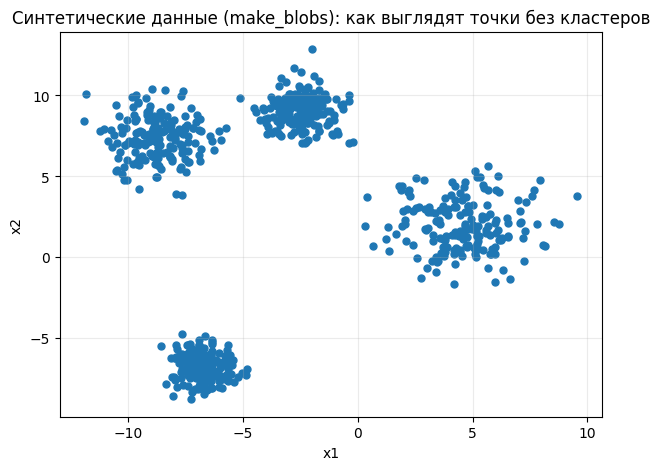

In [3]:
# Воспроизводимость
rng = 42

X, y_true = make_blobs(
    n_samples=700,
    centers=4,
    cluster_std=[1.0, 1.6, 0.8, 1.2],
    random_state=rng
)

plot_2d_points(X, title="Синтетические данные (make_blobs): как выглядят точки без кластеров")


## 3. KMeans “в лоб”: обучили и посмотрели кластеры

KMeans пытается найти такие центроиды, чтобы сумма квадратов расстояний от каждой точки до ближайшего центроида была минимальна.

Попробуем `K=4` (мы знаем, что центров 4 – потому что сами так сгенерировали данные).


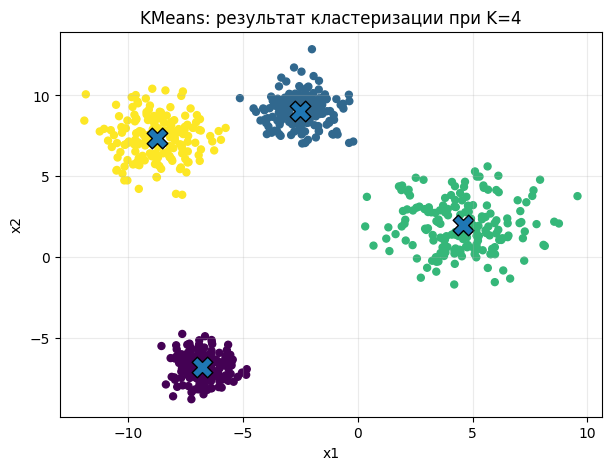

inertia_ = 1969.13
Число найденных кластеров = 4


In [4]:
k = 4
model = KMeans(n_clusters=k, n_init=10, random_state=42)
labels = model.fit_predict(X)

plot_2d_points(
    X, labels=labels, centers=model.cluster_centers_,
    title=f"KMeans: результат кластеризации при K={k}"
)

print("inertia_ =", round(model.inertia_, 2))
print("Число найденных кластеров =", len(np.unique(labels)))


## 4. Почему масштабирование признаков важно

KMeans использует **евклидово расстояние**.
Если один признак измеряется в условных “десятках”, а другой – в “тысячах”, то второй начнёт доминировать в расстоянии.

Сделаем простой эксперимент: “сломаем” масштаб одного признака (умножим `x1` на 10) и посмотрим, что будет.


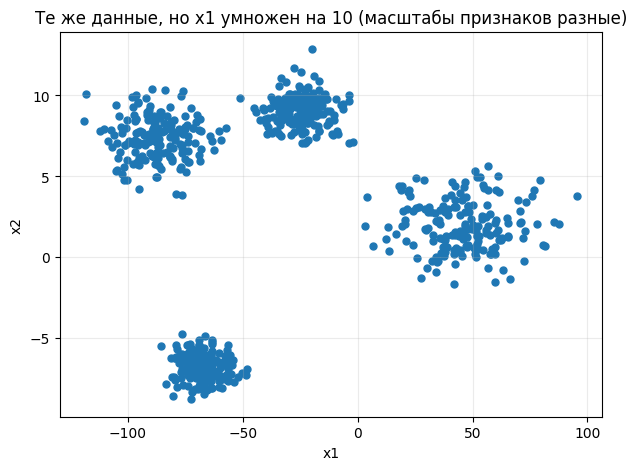

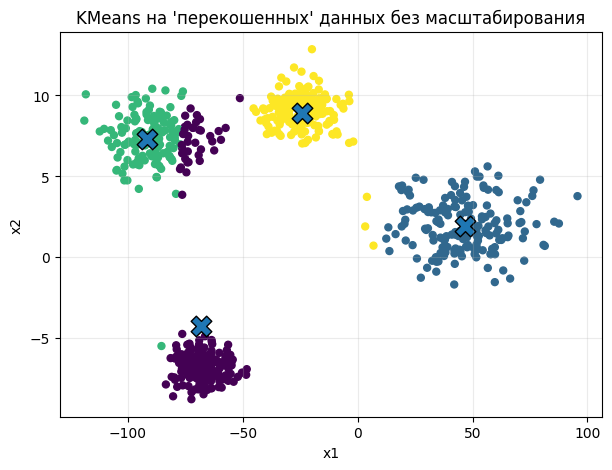

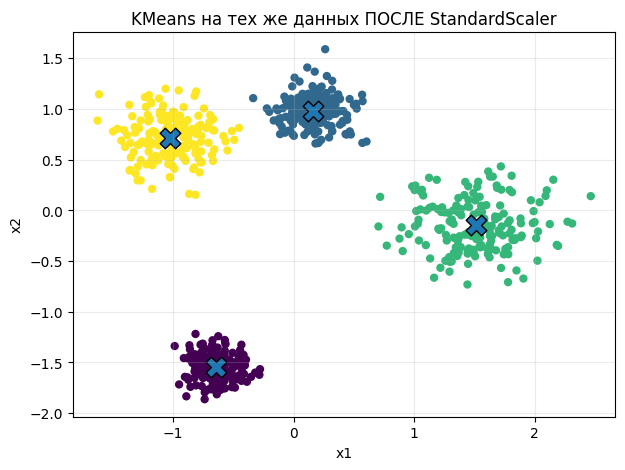

In [5]:
X_skew = X.copy()
X_skew[:, 0] *= 10  # искусственно увеличим масштаб первого признака

plot_2d_points(X_skew, title="Те же данные, но x1 умножен на 10 (масштабы признаков разные)")

model_bad = KMeans(n_clusters=4, n_init=10, random_state=42)
labels_bad = model_bad.fit_predict(X_skew)

plot_2d_points(
    X_skew, labels=labels_bad, centers=model_bad.cluster_centers_,
    title="KMeans на 'перекошенных' данных без масштабирования"
)

# Теперь исправим ситуацию StandardScaler'ом
scaler = StandardScaler()
X_skew_scaled = scaler.fit_transform(X_skew)

model_good = KMeans(n_clusters=4, n_init=10, random_state=42)
labels_good = model_good.fit_predict(X_skew_scaled)

plot_2d_points(
    X_skew_scaled, labels=labels_good, centers=model_good.cluster_centers_,
    title="KMeans на тех же данных ПОСЛЕ StandardScaler"
)


**Вывод:** для KMeans “по умолчанию” почти всегда стоит пробовать **StandardScaler** (особенно если признаки разномасштабные).
В реальных задачах это обычно делают через `Pipeline`, чтобы не забыть применить те же преобразования при повторном запуске.


## 5. Инициализация и устойчивость: почему `random_state` влияет

KMeans начинается с начальных центроидов.
Разные старты → разные локальные минимумы → иногда слегка разные результаты.

Параметр `n_init` говорит, сколько раз запускать алгоритм с разными инициализациями и выбирать лучший по `inertia_`.


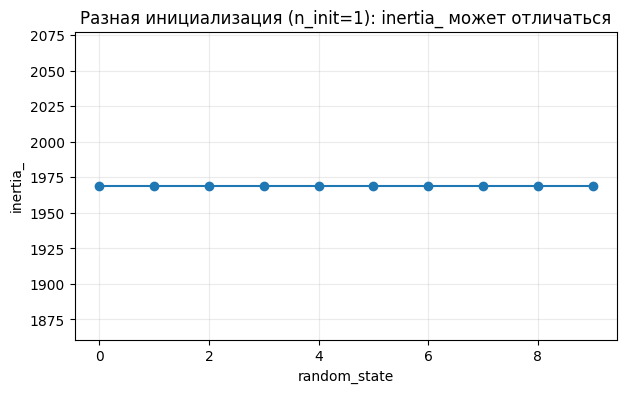

min inertia: 1969.13
max inertia: 1969.13


In [6]:
# Посмотрим, как меняется inertia_ при разных random_state
inertias = []
states = list(range(10))

for rs in states:
    m = KMeans(n_clusters=4, n_init=1, random_state=rs)
    m.fit(X)
    inertias.append(m.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(states, inertias, marker="o")
plt.title("Разная инициализация (n_init=1): inertia_ может отличаться")
plt.xlabel("random_state")
plt.ylabel("inertia_")
plt.grid(True, alpha=0.25)
plt.show()

print("min inertia:", round(float(np.min(inertias)), 2))
print("max inertia:", round(float(np.max(inertias)), 2))


Если поставить `n_init=10` (или больше), алгоритм становится заметно стабильнее – он выбирает лучший запуск.

*Практический смысл:* при сравнении моделей важно, чтобы вы не сравнивали “удачный старт” одной модели с “неудачным стартом” другой.


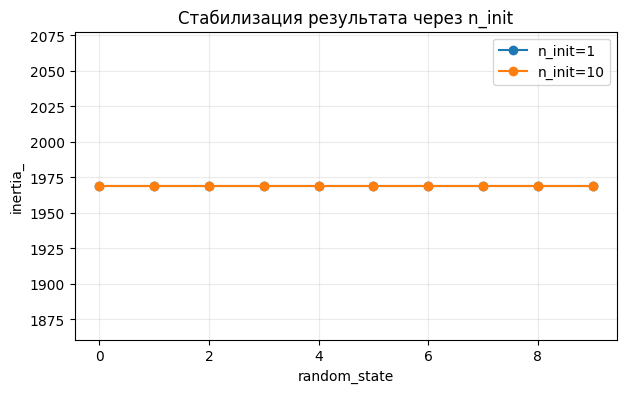

In [7]:
# Сравним разброс inertia_ при n_init=1 и n_init=10
inertias_1 = []
inertias_10 = []

for rs in states:
    m1 = KMeans(n_clusters=4, n_init=1, random_state=rs)
    m1.fit(X)
    inertias_1.append(m1.inertia_)

    m10 = KMeans(n_clusters=4, n_init=10, random_state=rs)
    m10.fit(X)
    inertias_10.append(m10.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(states, inertias_1, marker="o", label="n_init=1")
plt.plot(states, inertias_10, marker="o", label="n_init=10")
plt.title("Стабилизация результата через n_init")
plt.xlabel("random_state")
plt.ylabel("inertia_")
plt.grid(True, alpha=0.25)
plt.legend()
plt.show()


## 6. Как выбирать число кластеров K

У KMeans нет “встроенного правильного K”.
На практике комбинируют:
- инженерные ограничения (сколько сегментов нужно / сколько групп удобно интерпретировать);
- внутренние метрики качества;
- визуализацию (осторожно);
- устойчивость результатов.

Ниже – два стандартных приёма.


### 6.1 Elbow method (локоть) по `inertia_`

`inertia_` **всегда уменьшается**, когда K растёт (потому что центроидов больше, подгонка точнее).
Но часто есть момент, после которого улучшения становятся небольшими – “локоть”.


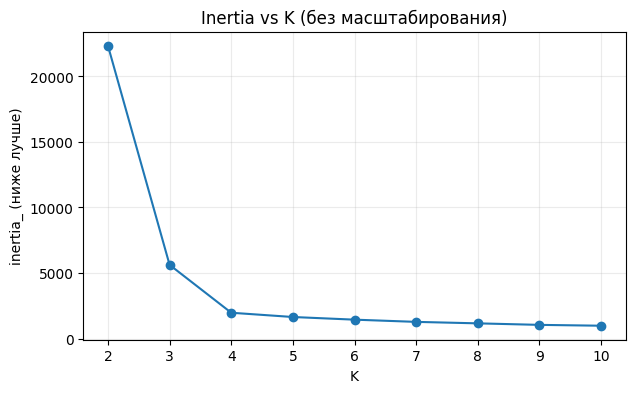

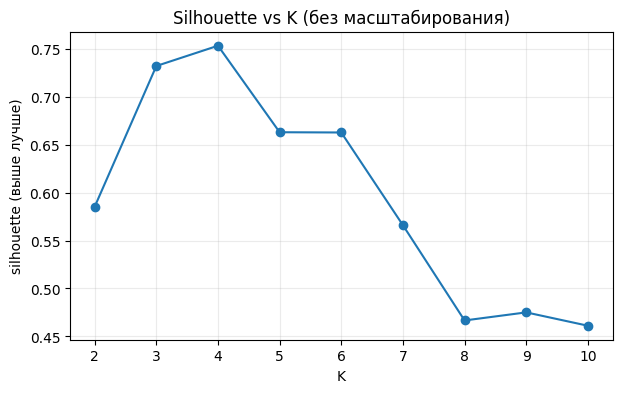

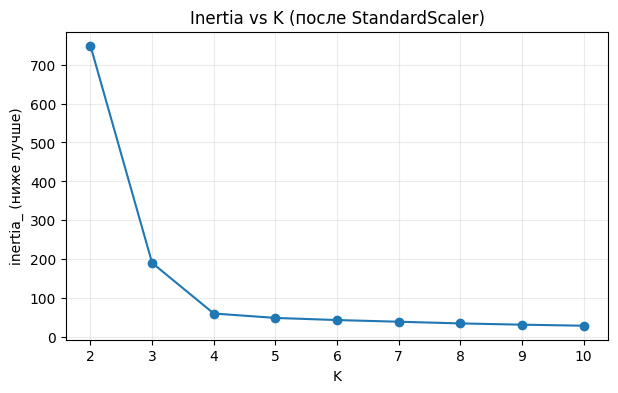

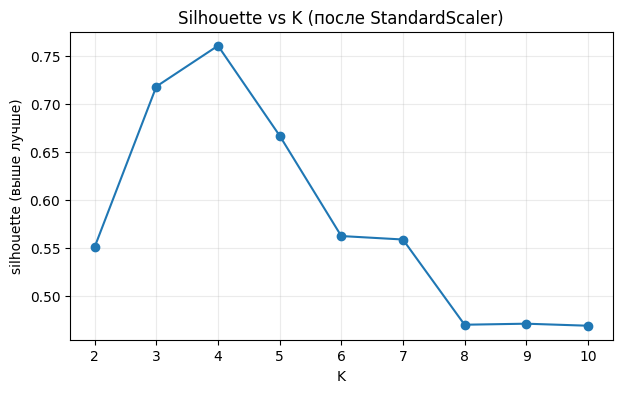

In [8]:
k_values = range(2, 11)

metrics_raw = evaluate_k_range(X, k_values, scale=False, random_state=42)
plot_k_metrics(metrics_raw, title_suffix=" (без масштабирования)")

metrics_scaled = evaluate_k_range(X, k_values, scale=True, random_state=42)
plot_k_metrics(metrics_scaled, title_suffix=" (после StandardScaler)")


### 6.2 Silhouette score (силуэт)

Интуиция: точка должна быть
- **близко** к точкам своего кластера,
- и **далеко** от ближайшего “чужого” кластера.

Силуэт ближе к 1 – лучше.

Но важно помнить:
- максимум силуэта не гарантирует “правильный” K;
- на данных со сложной геометрией (не “шарики”) силуэт может вести себя неочевидно.


## 7. Мини-эксперимент: KMeans на реальном встроенном датасете (Iris)

`Iris` – классический встроенный датасет `scikit-learn`.
Там 4 числовых признака, поэтому мы не можем “просто нарисовать” точки в 2D без преобразований.

Здесь мы сделаем простой вариант:
- масштабируем признаки;
- кластеризуем;
- посчитаем силуэт.

Мы **не пытаемся доказать**, что кластеры совпадают с истинными классами – это отдельная тема.


In [9]:
iris = load_iris()
X_iris = iris.data

scaler = StandardScaler()
X_iris_scaled = scaler.fit_transform(X_iris)

k = 3
model_iris = KMeans(n_clusters=k, n_init=20, random_state=42)
labels_iris = model_iris.fit_predict(X_iris_scaled)

print("Iris: inertia_ =", round(model_iris.inertia_, 3))
print("Iris: silhouette =", round(silhouette_score(X_iris_scaled, labels_iris), 3))
print("Размеры кластеров:", np.bincount(labels_iris))


Iris: inertia_ = 139.82
Iris: silhouette = 0.46
Размеры кластеров: [53 50 47]


Если очень хочется визуализации – можно сделать PCA до 2D и нарисовать (но помните: это уже **проекция**, а не исходное пространство).
В этом демо оставим это как упражнение ниже.


In [10]:
# Упражнение (по желанию):
# 1) примените PCA до 2D
# 2) нарисуйте точки и центры кластеров в PCA-пространстве
#
# Подсказка:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2, random_state=42)
# X2 = pca.fit_transform(X_iris_scaled)
# ...


## 8. Итоги

- KMeans – простой и быстрый базовый алгоритм кластеризации, но он чувствителен к масштабам признаков и предполагает “примерно сферические” кластеры.
- Перед KMeans почти всегда стоит попробовать `StandardScaler`.
- Для выбора `K` полезны:
  - elbow по `inertia_`;
  - silhouette score;
  - и здравый смысл: интерпретируемость и устойчивость результата.

**Дальше по плану семинара:** следующий демо-ноутбук логично посвятить DBSCAN – он лучше работает на “не-шарообразных” кластерах и умеет выделять шум.
